# Linear Regression the PyTorch Way

Task: fit a linear regression using gradient descent, with gradients computed by backpropagation using PyTorch

## Setup

In [1]:
import torch
from torch import tensor
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline

## Task

Suppose we have a dataset with just a single feature `x` and continuous outcome variable `y`.

In [2]:
import pandas as pd
data = pd.read_csv("https://data.giss.nasa.gov/gistemp/graphs_v4/graph_data/Global_Mean_Estimates_based_on_Land_and_Ocean_Data/graph.csv", skiprows=1)
data.head()

,Year,No_Smoothing,Lowess(5)
0,1880,-0.16,-0.09
1,1881,-0.08,-0.13
2,1882,-0.11,-0.16
3,1883,-0.17,-0.20
4,1884,-0.28,-0.24


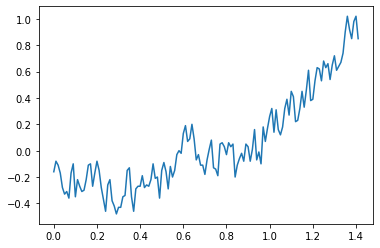

In [3]:
x = torch.tensor(data.iloc[:, 0], dtype=torch.float)
# scale x to a reasonable range
x -= 1880.0
x /= 100.
y_true = torch.tensor(data.iloc[:, 1])
plt.plot(x, y_true)

Create some features that we'll need later; don't worry about this code right now.

In [4]:
feats = torch.stack([x, x - 0.5], axis=1).clamp_min(0.0)
f1, f2 = feats.T

This Fundamentals notebook will be a bit different from usual: you'll be editing a *single* block of code. So the final notebook won't show your intermediate steps. That doesn't mean they aren't important; make sure you successfully complete each step before moving on to the next one.

Here is a basic outline for fitting a model using PyTorch. We'll be filling in the blanks here later. *Read the code and check that you understand the basic steps.*

Final Loss: 0.091


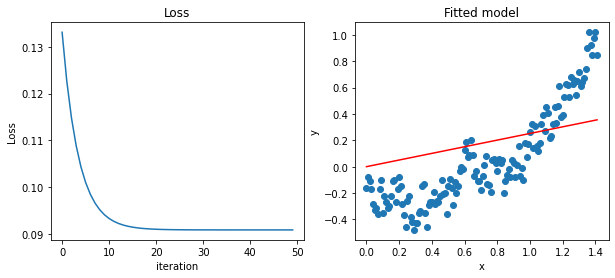

In [5]:
# Set hyperparameters
learning_rate = 0.1
num_iter = 50

# Initialize parameters
weights = torch.tensor([0.0], requires_grad=True)

# Keep a log of loss values
errors = []

# Repeat for each iteration
for i in range(num_iter):
    # Forward pass: compute loss
    # y_pred = ...
    y_pred = weights * x
    # resid = ...
    resid = y_true - y_pred
    # loss = ...
    loss = resid.pow(2).mean()
    errors.append(loss.item())

    # Backward pass: compute gradients
    loss.backward()
    
    # Descend the gradient.
    weights.data -= learning_rate * weights.grad
    
    # Clear out the gradient data so it doesn't corrupt the next iteration.
    weights.grad.zero_()

# Plot the results
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
axs[0].plot(errors)
axs[0].set(title="Loss", xlabel="iteration", ylabel="Loss")
axs[1].scatter(x, y_true)
axs[1].plot(x, y_pred.detach(), 'r');
axs[1].set(title="Fitted model", xlabel='x', ylabel='y')
print(f"Final Loss: {errors[-1]:.3f}")

### Step 1: Slope Only, MSE

Fill in the blanks in the code above so that it fits the model `y_pred = weights * x` to the data `x` and `y_true` in a way that minimizes the mean squared error (MSE).

Note that there is no intercept, so y_pred is 0.0 when x is 0.0.

Terminology:

- *weights*: the slope of the line
- *loss*: the mean squared error.

You should achieve a loss between 0.09 and 0.11.

### Step 2: Slope and intercept (aka weight and bias)

The model currently has a single parameter, `weights`. Now, incorporate another parameter into the model, `bias`. The new parameter should have the same shape as the output (in this case, a single number). The prediction equation will now be `y_pred = weights * x + bias`. Use the same data and loss function.

Terms:

- *bias*: the intercept of the line

You can initialize `bias` to 0 just like `weights`. (In general you'd use a random number, but this problem is well-behaved so zero will work.)

You should get an MSE of between 0.03 and 0.045.

Final MSE: 0.042


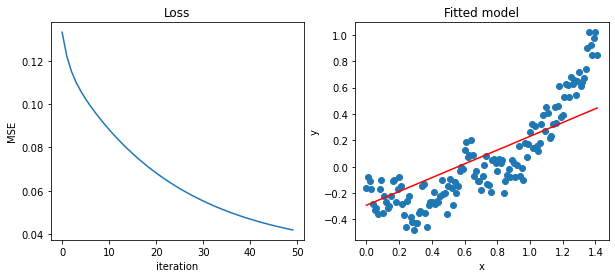

In [6]:
# remove
weights = torch.tensor([0.0], requires_grad=True)
bias = torch.tensor(0.0, requires_grad=True)

errors = []

for i in range(num_iter):
    # Forward pass:
    # y_pred = weights * x + bias
    y_pred = weights * x + bias
    # resid = ...
    resid = y_true - y_pred
    # mse = ...
    mse = resid.pow(2).mean()
    errors.append(mse.item())

    # Backward pass:
    mse.backward()
    
    # Descend the gradient.
    weights.data -= learning_rate * weights.grad
    # bias.data ...
    bias.data -= learning_rate * bias.grad
    
    # Clear out the gradient data for next time.
    weights.grad.zero_()
    bias.grad.zero_()

# Plot the results
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
axs[0].plot(errors)
axs[0].set(title="Loss", xlabel="iteration", ylabel="MSE")
axs[1].scatter(x, y_true)
axs[1].plot(x, y_pred.detach(), 'r');
axs[1].set(title="Fitted model", xlabel='x', ylabel='y')
print(f"Final MSE: {errors[-1]:.3f}")

### Step 3: Change the loss function

Now, minimize the Mean Absolute Error (mean of abs(resid)) instead of the MSE. Use the same model `y_pred = weights * x + bias` and data.

You should get an MAE of between 0.14 and 0.15.

Final loss: 0.150


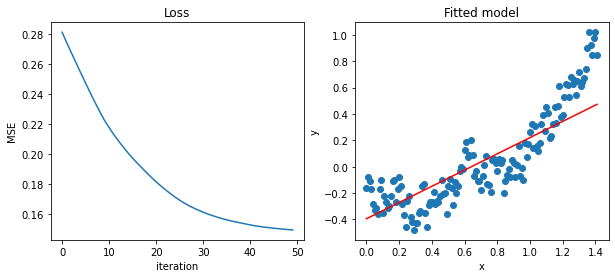

In [7]:
# remove
learning_rate = 0.1
weights = torch.tensor([0.0], requires_grad=True)
bias = torch.tensor(0.0, requires_grad=True)

errors = []

for i in range(num_iter):
    # Forward pass:
    # y_pred = weights * x + bias
    y_pred = weights * x + bias
    # resid = ...
    resid = y_true - y_pred
    # mae = ...
    mae = resid.abs().mean()
    errors.append(mae.item())

    # Backward pass:
    mae.backward()
    
    # Descend the gradient.
    weights.data -= learning_rate * weights.grad
    # bias.data ...
    bias.data -= learning_rate * bias.grad
    
    # Clear out the gradient data for next time.
    weights.grad.zero_()
    bias.grad.zero_()

# Plot the results
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
axs[0].plot(errors)
axs[0].set(title="Loss", xlabel="iteration", ylabel="MSE")
axs[1].scatter(x, y_true)
axs[1].plot(x, y_pred.detach(), 'r');
axs[1].set(title="Fitted model", xlabel='x', ylabel='y')
print(f"Final loss: {errors[-1]:.3f}")

## Step 4: Multiple linear regression

Note that the data seems to have different slopes in different parts. Ideally, rather than fitting a single line, we should fit a model where the slopes can change.

We can actually do this using linear regression in the same way as we did before. We can think of linear regression as mixing together some functions. In Steps 2 and 3 we mixed together two functions: an "always going up" function for x and a flat function, i.e., $f_1(x) = x$ and $f_2(x) = 1.0$.

Let's add another function into the mix. The easiest way to describe it is to see it:

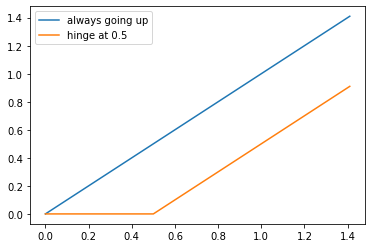

In [8]:
plt.plot(x, f1, label="always going up")
plt.plot(x, f2, label="hinge at 0.5")
plt.legend();

Why might that help us? Well, we can mix them together. Try adjusting the mixing weights to fit the data.

In [9]:
r = 2.0
@widgets.interact(w1=(-r, r), w2=(-r, r), bias=(-1.0, 1.0))
def plot_linreg(w1=.1, w2=-.3, bias=0.0):
    y_pred = w1 * f1 + w2 * f2 + bias
    plt.scatter(x, y_true)
    plt.plot(x, y_pred, 'r')
    resid = y_true - y_pred
    mse = resid.pow(2).mean()
    mae = resid.abs().mean()
    print(f"MSE: {mse}, MAE: {mae}")

interactive(children=(FloatSlider(value=0.1, description='w1', max=2.0, min=-2.0), FloatSlider(value=-0.3, des…

Now, edit your code block so that it fits the model `y_pred = w1 * f1 + w2 * f2 + bias`. Use MSE loss and the same data.

You should get an MSE between 0.01 and 0.03.

> There are two ways to do this. You can either:
>
> 1. Make a `tensor` for `w1` and another tensor for `w2`, then use the `y_pred` expression in `plot_linreg`, *or*
> 2. Add a second item to `weights`, and use `feats @ weights` (look back at Lab 1)... why does this work?

Final MSE: 0.028


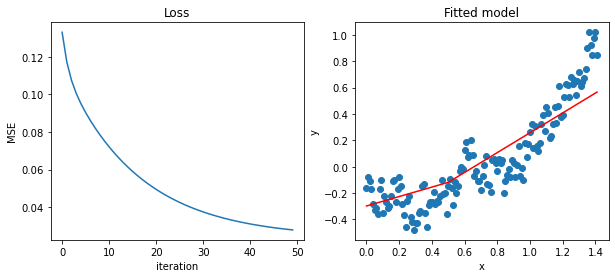

In [10]:
# remove
weights = torch.tensor([0.0, 0.0], requires_grad=True)
bias = torch.tensor(0.0, requires_grad=True)

errors = []

for i in range(num_iter):
    # Forward pass:
    y_pred = feats @ weights + bias
    resid = y_true - y_pred
    loss = resid.pow(2).mean()
    errors.append(loss.item())

    # Backward pass:
    loss.backward()
    
    # Descend the gradient.
    weights.data -= learning_rate * weights.grad
    bias.data -= learning_rate * bias.grad
    
    # Clear out the gradient data for next time.
    weights.grad.zero_()
    bias.grad.zero_()

# Plot the results
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
axs[0].plot(errors)
axs[0].set(title="Loss", xlabel="iteration", ylabel="MSE")
axs[1].scatter(x, y_true)
axs[1].plot(x, y_pred.detach(), 'r');
axs[1].set(title="Fitted model", xlabel='x', ylabel='y')
print(f"Final MSE: {errors[-1]:.3f}")